### Import Libraries

In [1]:
#Libs
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import Isomap
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from collections import defaultdict

2023-03-21 10:33:50.238195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Import Data

In [2]:
#data
dim_cd_df = pd.read_csv('../data/interim_data/dim_cd_df.csv',index_col=0)
dim_qq_df = pd.read_csv('../data/interim_data/dim_qq_df.csv',index_col=0)
FACT_df = pd.read_csv('../data/interim_data/FACT_df.csv',index_col=0)

### Subset and Merge Data

Since the data contains multiple languages and google translation services cost a fee, I'll subset the data to just us locations

In [3]:
#Subset the Fact table for only data from the US for 2020 and remove rows where the answer was NA
us_data = pd.merge(FACT_df,dim_cd_df[['Account_Num','Country','geometry']],on='Account_Num')

us_data.drop_duplicates(inplace=True)
us_data=us_data.query("Country == 'United States of America' & \
            Year ==2020 & \
            Answer not in ['Question not applicable','nan']")

#merge with dim_qq_df to add "Sect" to our df
us_data = pd.merge(us_data,dim_qq_df[['Question_ID','Sect']],on='Question_ID')

#drop null from answer
us_data.dropna(inplace=True)

In [4]:
#sample 5000 rows
us_data_sample = us_data.sample(5000).reset_index(drop=True)

us_data_sample.shape

(5000, 7)

In [5]:
us_data_sample.head()

Year  Account_Num  Question_ID  \
0  2020        31177         7624   
1  2020        54119          134   
2  2020        50560          648   
3  2020        54109        16572   
4  2020        43905        10011   

                                              Answer  \
0                                                Yes   
1                           Sea level rise modelling   
2  Disaster preparedness, Enhanced resilience, Di...   
3                                               2030   
4                                    Finance secured   

                    Country                  geometry                Sect  
0  United States of America  POINT (-111.891 40.7608)     Climate Hazards  
1  United States of America  POINT (-122.143 37.4419)  Adaptation Actions  
2  United States of America  POINT (-122.271 37.8044)  Adaptation Actions  
3  United States of America  POINT (-86.5264 39.1653)        City Details  
4  United States of America  POINT (-98.4936 29.4241)  Mitigation Actions

In [6]:
us_data_sample.Answer=us_data_sample.Answer.astype('str')

#  New Questions to Ask

## - What words are most prevelant in each section?
## - Are there clusters within the 'answers' feature?
## - If so, can we classify those clusters (per section)?
## - What does one cluster group per sector look like on a map?

##  What words are most prevelant in each section?

In [7]:
#!pip install spaCy           --install packages
#!python -m spacy download en_core_web_md    #--download english model

In [8]:
#use the medium sized model for vectorization
nlp = spacy.load("en_core_web_md")

In [9]:
#generate a corpus of answers
docs = list(nlp.pipe(us_data_sample.Answer))

In [10]:
#create a function to extract spacy attributes
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_.lower(), i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc
    ]

In [11]:
#create a df of those attributes
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df).reset_index(drop=True)

In [12]:
#create a new table of our answers broken down by spaCy attributes
tidy_doc = tidy_tokens(docs)
tidy_doc.head()

doc_id      token  token_order      lemma ent_type tag       dep   pos  \
0       0        Yes            0        yes           UH      ROOT  INTJ   
1       1        Sea            0        sea           NN  compound  NOUN   
2       1      level            1      level           NN  compound  NOUN   
3       1       rise            2       rise           NN  compound  NOUN   
4       1  modelling            3  modelling           NN      ROOT  NOUN   

   is_stop  is_alpha  is_digit  is_punct  
0    False      True     False     False  
1    False      True     False     False  
2    False      True     False     False  
3    False      True     False     False  
4    False      True     False     False

In [13]:
#Add an index to our US data
us_data_sample=us_data_sample.reset_index()

In [14]:
#merge to add question id and geometry
df_merge = pd.merge(tidy_doc,us_data_sample[['index','Sect','geometry']], 
                    left_on ='doc_id',right_on='index')
#drop the duplicate column 
df_merge.drop(columns='index',inplace=True)

#reorder
df_merge=df_merge[['Sect','doc_id','geometry',
                   'token','token_order','lemma',
                   'ent_type','tag','dep',
                   'pos','is_stop','is_alpha',
                   'is_digit','is_punct']]

In [15]:
#Now we can sort by Question ID
df_merge.sort_values(['Sect','doc_id','token_order']).head()

Sect  doc_id                  geometry      token  \
1  Adaptation Actions       1  POINT (-122.143 37.4419)        Sea   
2  Adaptation Actions       1  POINT (-122.143 37.4419)      level   
3  Adaptation Actions       1  POINT (-122.143 37.4419)       rise   
4  Adaptation Actions       1  POINT (-122.143 37.4419)  modelling   
5  Adaptation Actions       2  POINT (-122.271 37.8044)   Disaster   

   token_order      lemma ent_type tag       dep   pos  is_stop  is_alpha  \
1            0        sea           NN  compound  NOUN    False      True   
2            1      level           NN  compound  NOUN    False      True   
3            2       rise           NN  compound  NOUN    False      True   
4            3  modelling           NN      ROOT  NOUN    False      True   
5            0   disaster           NN  compound  NOUN    False      True   

   is_digit  is_punct  
1     False     False  
2     False     False  
3     False     False  
4     False     False  
5     False     False

In [16]:
#lets investigate the POS of 'SPACE'
#this will take the spaces and place the "prevous and next tokens" around the space. 
(df_merge
 .groupby("doc_id")
 .apply(lambda x: x.assign(
     prev_token = lambda x: x.token.shift(1), 
     next_token = lambda x: x.token.shift(-1))
       )
 .reset_index(drop=True)
 .query("pos == 'SPACE'")
 .loc[:, ["doc_id", "prev_token", "token", "next_token"]]
).head()

doc_id prev_token token next_token
721       50          .                (
2074     111          .           Causes
2254     124    mapping               is
2583     128          .              The
3778     215        are         2,003.14

the space is just a typo error of an additional space

In [17]:
#Subset DF to remove stopwords, punctuation and SPACE p.o.s
df_merge_simplified=df_merge.query("is_stop == False & is_punct == False & pos != 'SPACE'")
df_merge_simplified

Sect  doc_id                  geometry        token  \
0         Climate Hazards       0  POINT (-111.891 40.7608)          Yes   
1      Adaptation Actions       1  POINT (-122.143 37.4419)          Sea   
2      Adaptation Actions       1  POINT (-122.143 37.4419)        level   
3      Adaptation Actions       1  POINT (-122.143 37.4419)         rise   
4      Adaptation Actions       1  POINT (-122.143 37.4419)    modelling   
...                   ...     ...                       ...          ...   
71165  Mitigation Actions    4999  POINT (-111.498 40.6461)  Feasibility   
71166  Mitigation Actions    4999  POINT (-111.498 40.6461)    finalized   
71169  Mitigation Actions    4999  POINT (-111.498 40.6461)      finance   
71170  Mitigation Actions    4999  POINT (-111.498 40.6461)    partially   
71171  Mitigation Actions    4999  POINT (-111.498 40.6461)      secured   

       token_order        lemma ent_type  tag       dep    pos  is_stop  \
0                0          yes            UH      ROOT   INTJ    False   
1                0          sea            NN  compound   NOUN    False   
2                1        level            NN  compound   NOUN    False   
3                2         rise            NN  compound   NOUN    False   
4                3    modelling            NN      ROOT   NOUN    False   
...            ...          ...      ...  ...       ...    ...      ...   
71165            0  feasibility           NNP     nsubj  PROPN    False   
71166            1     finalize           VBN      ROOT   VERB    False   
71169            4      finance            NN     nsubj   NOUN    False   
71170            5    partially            RB    advmod    ADV    False   
71171            6       secure           VBN      conj   VERB    False   

       is_alpha  is_digit  is_punct  
0          True     False     False  
1          True     False     False  
2          True     False     False  
3          True     False     False  
4          True     False     False  
...         ...       ...       ...  
71165      True     False     False  
71166      True     False     False  
71169      True     False     False  
71170      True     False     False  
71171      True     False     False  

[42231 rows x 14 columns]

### Text Exploration

In [18]:
#How many unique sectors are there?
len(df_merge_simplified.Sect.unique())

24

In [19]:
#unique lemma per sector
unique_lemma = df_merge_simplified.groupby('Sect')['lemma'].nunique().sort_values(ascending=False)
unique_lemma.head(10)

Sect
Climate Hazards                              1759
Adaptation Actions                           1446
Mitigation Actions                           1381
Governance                                    973
Opportunities                                 923
Climate Risk and Vulnerability Assessment     906
Finance and Economic Opportunities            785
Water Supply Management                       748
Collaboration                                 578
Adaptation Goals                              578
Name: lemma, dtype: int64

In [20]:
#number of different doc_id per group
unique_doc_id = df_merge_simplified.groupby('Sect')['doc_id'].nunique().sort_values(ascending=False)
unique_doc_id

Sect
Climate Hazards                                   906
City-wide GHG Emissions Data                      673
Mitigation Actions                                629
Adaptation Actions                                603
GCoM Emission Factor and Activity Data            322
Mitigation Target setting                         182
Finance and Economic Opportunities                175
Climate Risk and Vulnerability Assessment         147
Water Supply Management                           137
Mitigation Planning                               122
Opportunities                                     118
Historical emissions inventories                  118
Adaptation Planning                               113
City Details                                      113
Water Supply                                      111
Adaptation Goals                                  108
Governance                                         90
Collaboration                                      89
Local Government Operat

Intersting to see the few responses for sectors such as urban planning, data management, and adaptation planning processes. We will subset these values for sectors with more than 20 responses

In [21]:
unique_doc_id = unique_doc_id.loc[unique_doc_id.values > 20].sort_values(ascending=False)
unique_doc_id.head(10)

Sect
Climate Hazards                              906
City-wide GHG Emissions Data                 673
Mitigation Actions                           629
Adaptation Actions                           603
GCoM Emission Factor and Activity Data       322
Mitigation Target setting                    182
Finance and Economic Opportunities           175
Climate Risk and Vulnerability Assessment    147
Water Supply Management                      137
Mitigation Planning                          122
Name: doc_id, dtype: int64

In [22]:
#The average number of unique Lemma per answer
words_per_id = unique_lemma/unique_doc_id
words_per_id = (words_per_id.loc[words_per_id.notnull()].sort_values(ascending=False)).astype('int')
words_per_id.head(10)

Sect
Governance                                   10
Opportunities                                 7
Collaboration                                 6
Climate Risk and Vulnerability Assessment     6
Re-stating previous emissions inventories     5
Water Supply Management                       5
Adaptation Goals                              5
Adaptation Planning                           4
Finance and Economic Opportunities            4
Mitigation Planning                           4
dtype: int64

In [23]:
#subset our data to important features
data_sect_id_pos_lemma =df_merge_simplified[['Sect','doc_id','pos','lemma']]\
                        .sort_values(['Sect','doc_id','pos'])
data_sect_id_pos_lemma

Sect  doc_id    pos         lemma
1           Adaptation Actions       1   NOUN           sea
2           Adaptation Actions       1   NOUN         level
3           Adaptation Actions       1   NOUN          rise
4           Adaptation Actions       1   NOUN     modelling
8           Adaptation Actions       2    ADJ      enhanced
...                        ...     ...    ...           ...
68429  Water Supply Management    4849  PROPN          plan
68617  Water Supply Management    4873   NOUN  preservation
68616  Water Supply Management    4873  PROPN     watershed
69980  Water Supply Management    4891   NOUN    monitoring
69982  Water Supply Management    4891   VERB        report

[42231 rows x 4 columns]

In [24]:
#Count of words per sector. Lets remove those with less than 30 words

#subset the table above for section and lemma
lemma_counts =data_sect_id_pos_lemma[['Sect','lemma']]

#group by Sect, count # of lemma, and sort values 
lemma_counts_grouped = lemma_counts.groupby('Sect',as_index=False)\
                        .lemma.count()\
                        .sort_values('lemma',ascending=False)

#create a list of counts above 30. Anything less won't be great for analysis
sects_over_30 = list(lemma_counts_grouped.loc[lemma_counts_grouped.lemma > 30].Sect)

#show the first 10 rows
sects_over_30[:10]

['Climate Hazards',
 'Adaptation Actions',
 'Mitigation Actions',
 'Governance',
 'Climate Risk and Vulnerability Assessment',
 'Opportunities',
 'Finance and Economic Opportunities',
 'City-wide GHG Emissions Data',
 'Water Supply Management',
 'Adaptation Goals']

In [25]:
#show a table of our sectors with over 30 lemma 
lemma_counts_grouped_w_rank= lemma_counts.groupby('Sect',as_index=False).lemma.value_counts()
lemma_counts_grouped_w_rank_30=lemma_counts_grouped_w_rank.loc[lemma_counts_grouped_w_rank.Sect.isin(sects_over_30)]

lemma_counts_grouped_w_rank_30

Sect           lemma  count
0           Adaptation Actions           water    134
1           Adaptation Actions           flood     88
2           Adaptation Actions            city     78
3           Adaptation Actions               >     75
4           Adaptation Actions  infrastructure     65
...                        ...             ...    ...
13512  Water Supply Management             100      1
13513  Water Supply Management              14      1
13514  Water Supply Management              17      1
13515  Water Supply Management            1978      1
13516  Water Supply Management               1      1

[13493 rows x 3 columns]

In [26]:
#Let's add a dense rank so we can eventually pull out the top 30 words per sector  

#group by Section, and get VALUE_COUNTS of lemma (different than above)
lemma_counts_grouped_w_rank= lemma_counts.groupby('Sect',as_index=False).lemma.value_counts()

#subet the sections for only thoe in sects_over_30.
lemma_counts_grouped_w_rank_30=lemma_counts_grouped_w_rank_30.loc\
            [lemma_counts_grouped_w_rank_30.Sect.isin(sects_over_30)]

#Add a rank so we can subset for top 30 by sector (Dense rank)
lemma_counts_grouped_w_rank_30['dense_rank'] = lemma_counts_grouped_w_rank_30\
            .sort_values(['Sect','count'], ascending=[True,False]) \
            .groupby(['Sect'])['count']\
            .rank(method='dense', ascending=False) \
            .astype(int)

#filter for dense_rank <=30. We only want top 30 words
lemma_counts_grouped_w_rank_30 = lemma_counts_grouped_w_rank_30.loc[lemma_counts_grouped_w_rank_30.dense_rank <=30]
lemma_counts_grouped_w_rank_30


Sect           lemma  count  dense_rank
0           Adaptation Actions           water    134           1
1           Adaptation Actions           flood     88           2
2           Adaptation Actions            city     78           3
3           Adaptation Actions               >     75           4
4           Adaptation Actions  infrastructure     65           5
...                        ...             ...    ...         ...
13512  Water Supply Management             100      1          21
13513  Water Supply Management              14      1          21
13514  Water Supply Management              17      1          21
13515  Water Supply Management            1978      1          21
13516  Water Supply Management               1      1          21

[8333 rows x 4 columns]

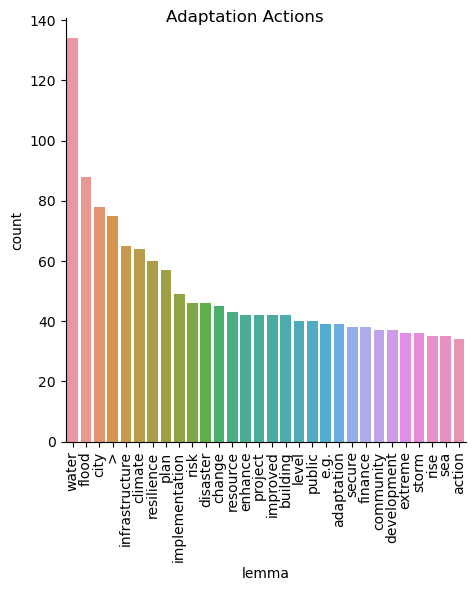

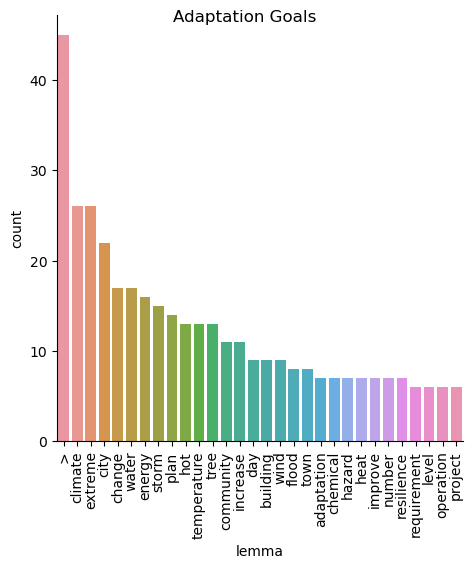

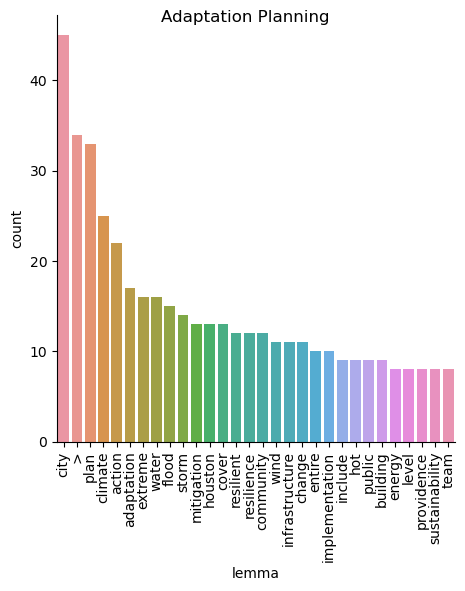

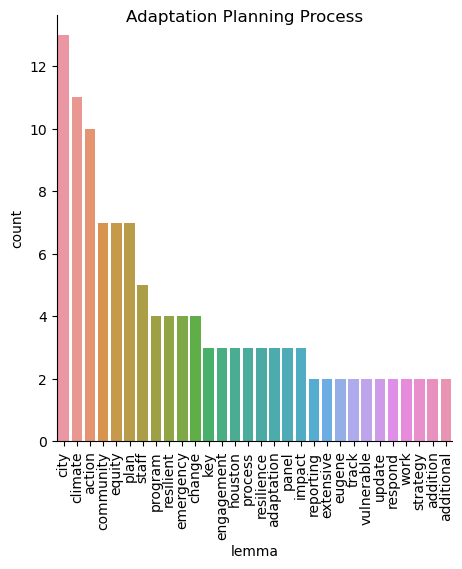

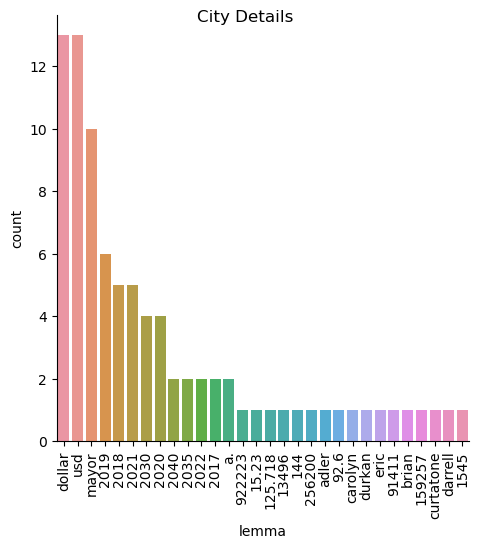

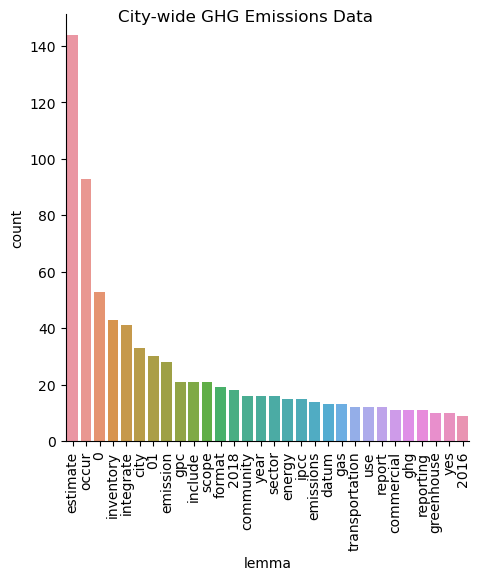

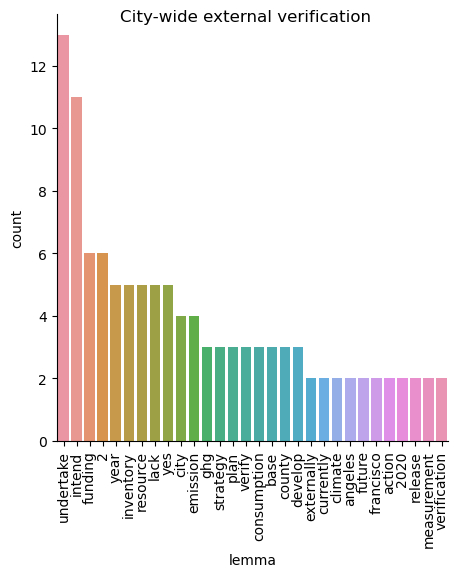

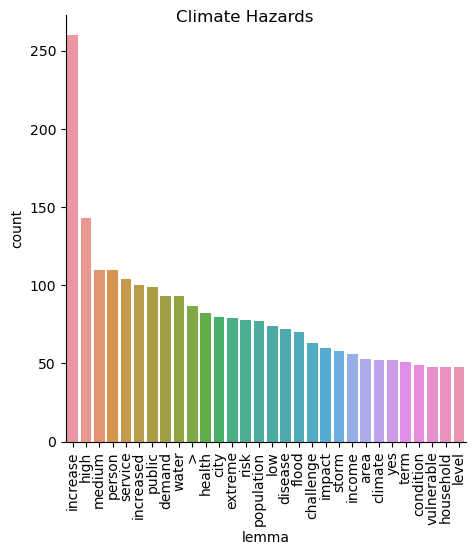

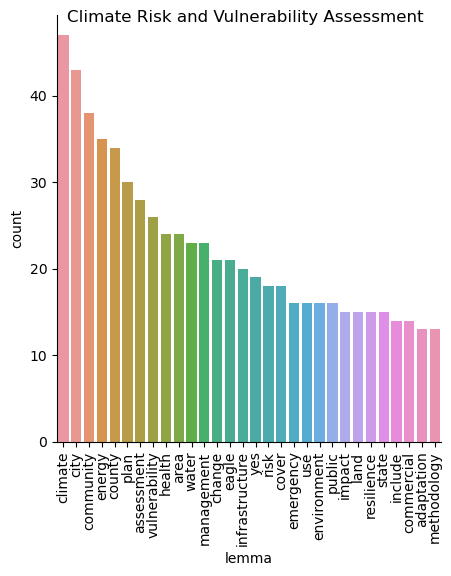

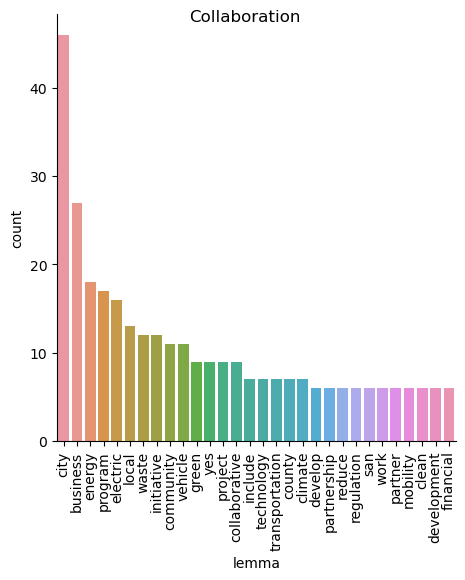

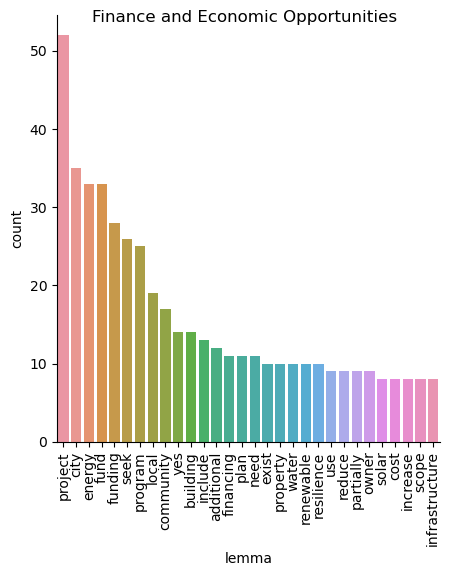

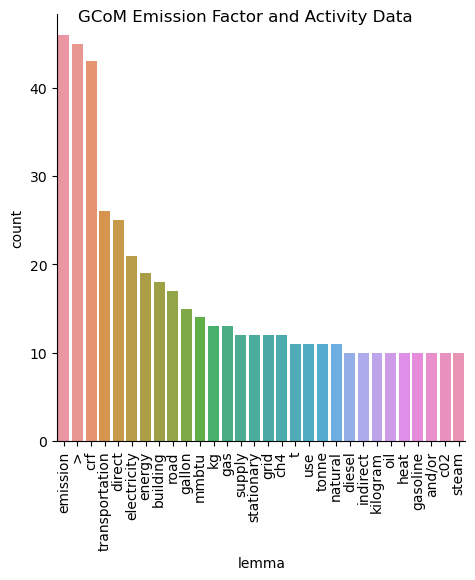

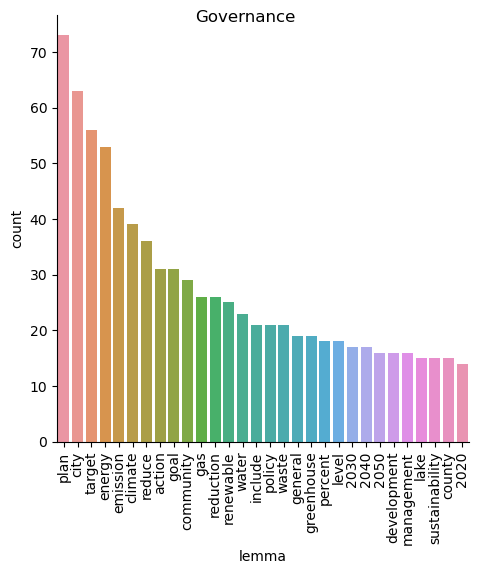

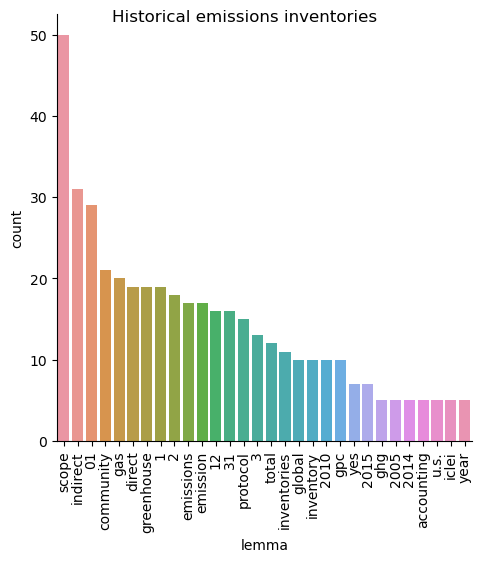

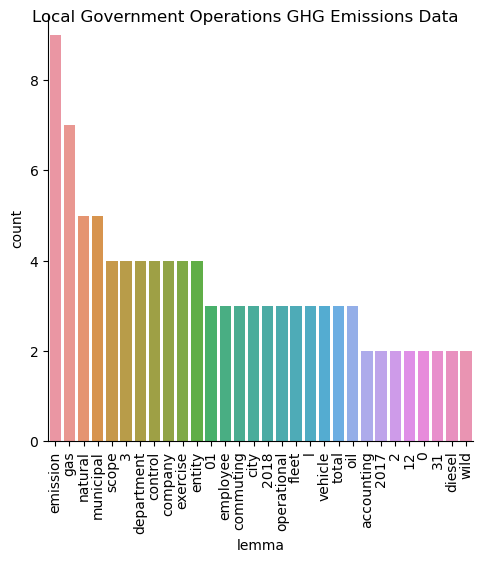

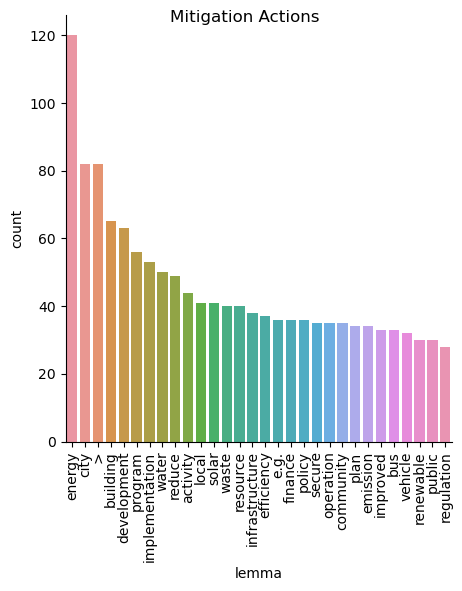

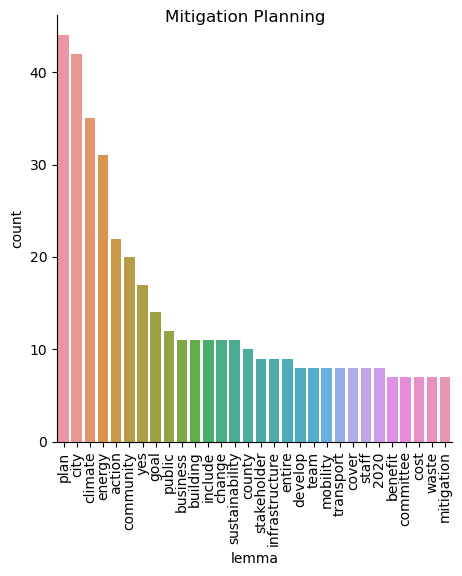

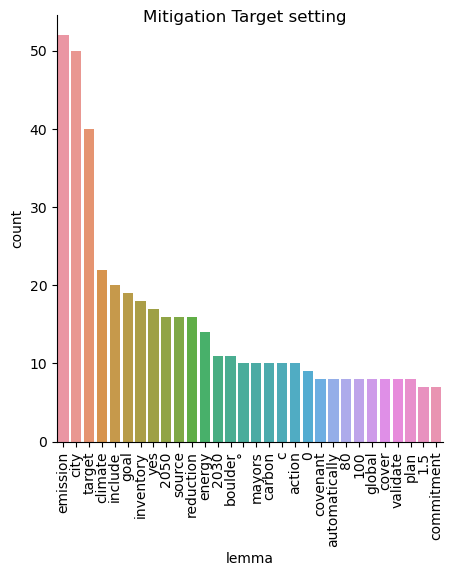

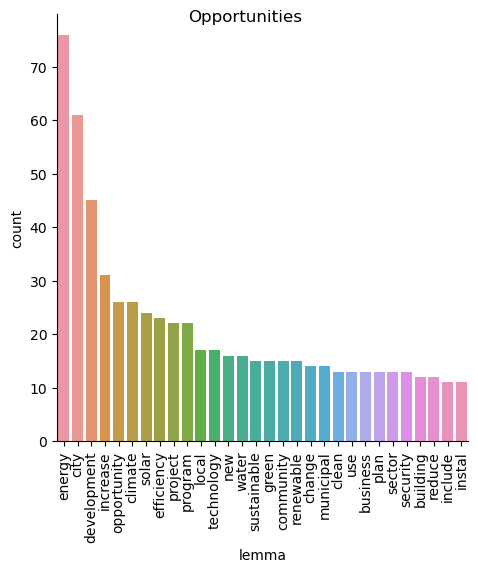

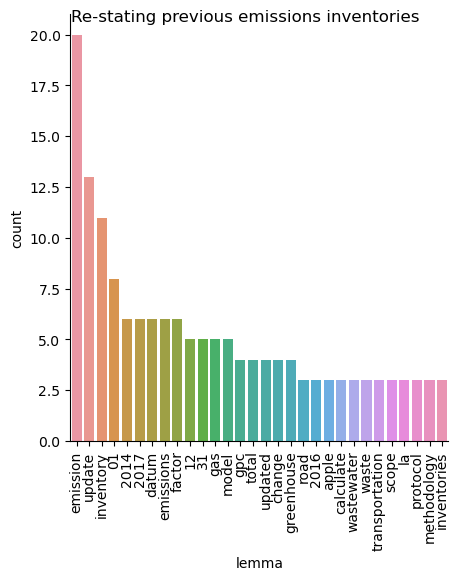

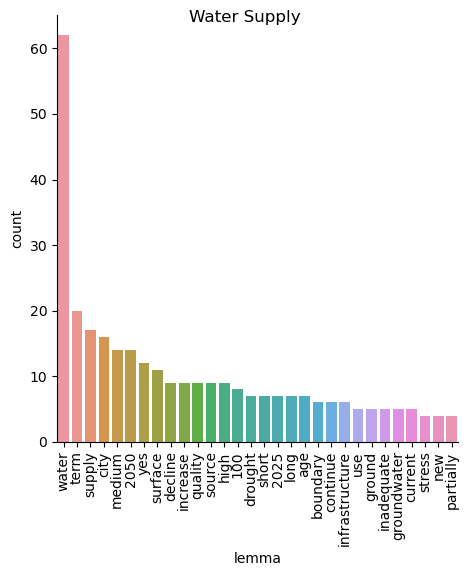

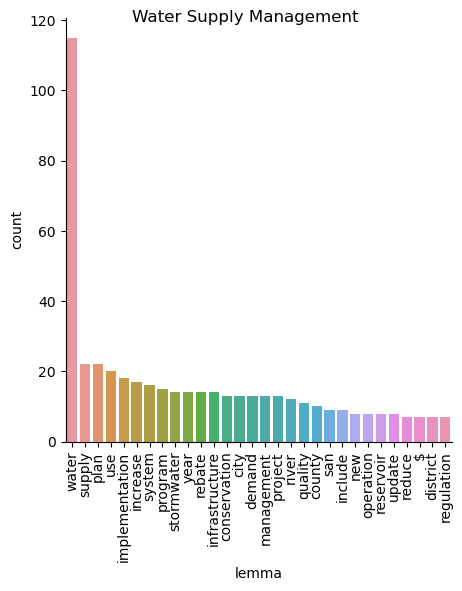

In [27]:
#Counts of top 30 lemma by subsector- graphs (just show 30 )

#for each section, create a plot
for sect in lemma_counts_grouped_w_rank_30.Sect.unique():
    
    #bar plot
    p=sns.catplot(kind='bar',\
                  data=lemma_counts_grouped_w_rank.loc[lemma_counts_grouped_w_rank.Sect==sect].sort_values("count",ascending=False).head(30),
                  x='lemma',
                  y='count')
    p.fig.suptitle(sect)
    p.set_xticklabels(rotation=90)
plt.show()

### We now have most common words per sector

In [28]:
#lets compress the data frame. for each sector, create a list of the lemmas
lemma_counts_grouped_w_rank_30_list = lemma_counts_grouped_w_rank_30.groupby('Sect')['lemma'].apply(list)

#turn it into a DF
lemma_counts_grouped_w_rank_30_list=pd.DataFrame(lemma_counts_grouped_w_rank_30_list).reset_index()
lemma_counts_grouped_w_rank_30_list.columns=['Sect','Common_Words']
lemma_counts_grouped_w_rank_30_list.head(10)

Sect  \
0                         Adaptation Actions   
1                           Adaptation Goals   
2                        Adaptation Planning   
3                Adaptation Planning Process   
4                               City Details   
5               City-wide GHG Emissions Data   
6            City-wide external verification   
7                            Climate Hazards   
8  Climate Risk and Vulnerability Assessment   
9                              Collaboration   

                                        Common_Words  
0  [water, flood, city, >, infrastructure, climat...  
1  [>, extreme, climate, city, change, water, ene...  
2  [city, >, plan, climate, action, adaptation, e...  
3  [city, climate, action, community, equity, pla...  
4  [dollar, usd, mayor, 2019, 2018, 2021, 2030, 2...  
5  [estimate, occur, 0, inventory, integrate, cit...  
6  [undertake, intend, funding, 2, year, inventor...  
7  [increase, high, medium, person, service, incr...  
8  [climate, city, community, energy, county, pla...  
9  [city, business, energy, program, electric, lo...

### Lets find the proportion of words per doc_id that are in the list

In [29]:
#create dataframe of the two tables to include common_words to the list
merged_df = pd.merge(data_sect_id_pos_lemma,lemma_counts_grouped_w_rank_30_list,on='Sect')
merged_df

Sect  doc_id    pos         lemma  \
0           Adaptation Actions       1   NOUN           sea   
1           Adaptation Actions       1   NOUN         level   
2           Adaptation Actions       1   NOUN          rise   
3           Adaptation Actions       1   NOUN     modelling   
4           Adaptation Actions       2    ADJ      enhanced   
...                        ...     ...    ...           ...   
42195  Water Supply Management    4849  PROPN          plan   
42196  Water Supply Management    4873   NOUN  preservation   
42197  Water Supply Management    4873  PROPN     watershed   
42198  Water Supply Management    4891   NOUN    monitoring   
42199  Water Supply Management    4891   VERB        report   

                                            Common_Words  
0      [water, flood, city, >, infrastructure, climat...  
1      [water, flood, city, >, infrastructure, climat...  
2      [water, flood, city, >, infrastructure, climat...  
3      [water, flood, city, >, infrastructure, climat...  
4      [water, flood, city, >, infrastructure, climat...  
...                                                  ...  
42195  [water, plan, supply, use, implementation, inc...  
42196  [water, plan, supply, use, implementation, inc...  
42197  [water, plan, supply, use, implementation, inc...  
42198  [water, plan, supply, use, implementation, inc...  
42199  [water, plan, supply, use, implementation, inc...  

[42200 rows x 5 columns]

In [30]:
#If lemma is in common_words, return true, else false
merged_df['In']=merged_df.apply(lambda row: row['lemma'] in row['Common_Words'],axis=1)
merged_df.head()

Sect  doc_id   pos      lemma  \
0  Adaptation Actions       1  NOUN        sea   
1  Adaptation Actions       1  NOUN      level   
2  Adaptation Actions       1  NOUN       rise   
3  Adaptation Actions       1  NOUN  modelling   
4  Adaptation Actions       2   ADJ   enhanced   

                                        Common_Words     In  
0  [water, flood, city, >, infrastructure, climat...   True  
1  [water, flood, city, >, infrastructure, climat...   True  
2  [water, flood, city, >, infrastructure, climat...   True  
3  [water, flood, city, >, infrastructure, climat...  False  
4  [water, flood, city, >, infrastructure, climat...   True

In [31]:
#create a temp table that adds up the "In" column and dividides by total number of "In" rows per dic_id
temp_merge = merged_df.groupby(['Sect','doc_id'],as_index=False).agg(Words_In_List = ('In','sum'),Total_Words=('In','count'))
temp_merge['Word_Proportion']= temp_merge['Words_In_List']/ temp_merge['Total_Words']
final_merge=temp_merge[['Sect','doc_id','Word_Proportion']]
final_merge

Sect  doc_id  Word_Proportion
0          Adaptation Actions       1         0.750000
1          Adaptation Actions       2         0.857143
2          Adaptation Actions       8         0.000000
3          Adaptation Actions      20         0.250000
4          Adaptation Actions      27         0.000000
...                       ...     ...              ...
4888  Water Supply Management    4668         1.000000
4889  Water Supply Management    4746         1.000000
4890  Water Supply Management    4849         1.000000
4891  Water Supply Management    4873         1.000000
4892  Water Supply Management    4891         1.000000

[4893 rows x 3 columns]

In [32]:
#join to expand doc_id into account_num and question_ID
df_merge_by_sect = pd.merge(final_merge,us_data_sample[['index','Account_Num','Question_ID']],\
         left_on='doc_id',right_on='index')\
[['Account_Num','Question_ID','Sect','Word_Proportion']]

#average the word_proportion for each sector/Account_Num 
df_merge_by_sect.groupby(['Account_Num','Sect'],as_index=False)['Word_Proportion'].mean()

Account_Num                          Sect  Word_Proportion
0            1184            Adaptation Actions         0.352414
1            1184              Adaptation Goals         1.000000
2            1184   Adaptation Planning Process         1.000000
3            1184                  City Details         1.000000
4            1184  City-wide GHG Emissions Data         1.000000
...           ...                           ...              ...
1298       841964               Climate Hazards         0.411458
1299       841964                 Collaboration         1.000000
1300       841964            Mitigation Actions         0.535714
1301       841964     Mitigation Target setting         1.000000
1302       841964                  Water Supply         1.000000

[1303 rows x 3 columns]

## Are there clusters within the 'answers' feature?

In [33]:
#Check the Sect. We may want to remove a few of the 'boring' sectors from the analysis
us_sect_mask = us_data_sample.groupby('Sect')['Question_ID'].count().sort_values(ascending=False)
us_sect_mask

Sect
Climate Hazards                                   923
City-wide GHG Emissions Data                      673
Mitigation Actions                                629
Adaptation Actions                                603
GCoM Emission Factor and Activity Data            322
Mitigation Target setting                         195
Finance and Economic Opportunities                180
Climate Risk and Vulnerability Assessment         151
Water Supply Management                           140
Historical emissions inventories                  130
Water Supply                                      125
Mitigation Planning                               122
Adaptation Goals                                  118
Opportunities                                     118
Adaptation Planning                               113
City Details                                      113
Governance                                         90
Collaboration                                      89
Local Government Operat

we will subset for sectors with atleast 30 rows of answers

In [34]:
us_data_sample.drop(columns='index',inplace=True)

In [35]:
us_sect_mask = us_sect_mask.loc[us_sect_mask.values>30].index
us_data_sample=us_data_sample.loc[us_data_sample.Sect.isin(us_sect_mask)]
us_data_sample

Year  Account_Num  Question_ID  \
0     2020        31177         7624   
1     2020        54119          134   
2     2020        50560          648   
3     2020        54109        16572   
4     2020        43905        10011   
...    ...          ...          ...   
4995  2020        58485          765   
4996  2020        49333         4004   
4997  2020        58871         8386   
4998  2020        43910        10509   
4999  2020        14344        10035   

                                                 Answer  \
0                                                   Yes   
1                              Sea level rise modelling   
2     Disaster preparedness, Enhanced resilience, Di...   
3                                                  2030   
4                                       Finance secured   
...                                                 ...   
4995                                              Water   
4996                                            2795130   
4997  Some critical facilities will be affected. Pow...   
4998  https://www.cota.com/initiatives/cmax-bus-rapi...   
4999  Feasibility finalized, and finance partially s...   

                       Country                  geometry  \
0     United States of America  POINT (-111.891 40.7608)   
1     United States of America  POINT (-122.143 37.4419)   
2     United States of America  POINT (-122.271 37.8044)   
3     United States of America  POINT (-86.5264 39.1653)   
4     United States of America  POINT (-98.4936 29.4241)   
...                        ...                       ...   
4995  United States of America  POINT (-75.1195 40.1241)   
4996  United States of America   POINT (-85.6784 38.196)   
4997  United States of America  POINT (-70.8967 42.5195)   
4998  United States of America  POINT (-82.9988 39.9612)   
4999  United States of America  POINT (-111.498 40.6461)   

                              Sect  
0                  Climate Hazards  
1               Adaptation Actions  
2               Adaptation Actions  
3                     City Details  
4               Mitigation Actions  
...                            ...  
4995            Adaptation Actions  
4996  City-wide GHG Emissions Data  
4997               Climate Hazards  
4998            Mitigation Actions  
4999            Mitigation Actions  

[4975 rows x 7 columns]

In [36]:
us_data_sample.Answer=us_data_sample.Answer.astype('str')

In [37]:
#Create a corpus of Answers
doc = list(nlp.pipe(us_data_sample.Answer))

In [38]:
#vectorize it
vectors=[tokens.vector for tokens in doc]

In [39]:
#isometric mapping

### Step 1 - Configure the Isomap function, note we use default hyperparameter values in this example
embed3 = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=3, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)

### Step 2 - Fit the data and transform it, so we have 3 dimensions instead of 64
X_trans3 = embed3.fit_transform(vectors)
    
### Step 3 - Print shape to test
print('The new shape of X: ',X_trans3.shape)

The new shape of X:  (4975, 3)


In [40]:
y=us_data_sample.Sect
y.shape

(4975,)

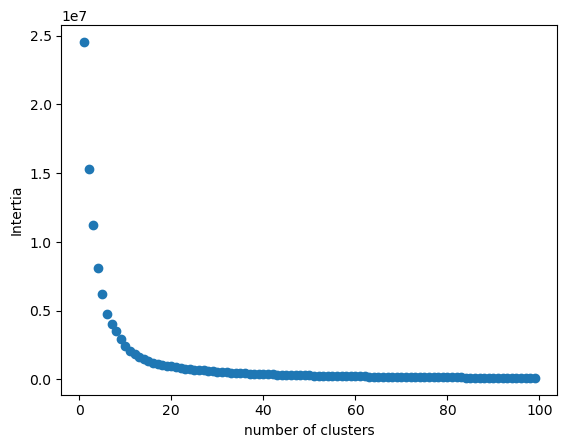

In [41]:
#Elbow plot to determine k neighbrs
x_cols = np.array(X_trans3)
inertia = []

Ks=range(1,100)

for k in Ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertia.append(model.inertia_)

plt.scatter(Ks,inertia)
plt.xlabel("number of clusters")
plt.ylabel("Intertia")
plt.show()

In [42]:
#Create our KMEANS model but with 10 clusters
model = KMeans(n_clusters = 10, random_state = 10)
model.fit(x_cols)
labels = model.predict(x_cols)
labels.shape

Account_Num = us_data_sample.Sect.index

#create a table with the cluster_ID added to Account_Num
cluster_df = pd.DataFrame({'Account_Num':Account_Num, 'Cluster ID':labels})
cluster_df


Account_Num  Cluster ID
0               0           7
1               1           1
2               2           4
3               3           1
4               4           1
...           ...         ...
4970         4995           4
4971         4996           6
4972         4997           2
4973         4998           6
4974         4999           1

[4975 rows x 2 columns]

In [43]:
#expand the X,Y,Z
cluster_df['X']=X_trans3[:,0]
cluster_df['Y']=X_trans3[:,1]
cluster_df['Z']=X_trans3[:,2]
cluster_df

Account_Num  Cluster ID          X          Y          Z
0               0           7 -38.059463  40.604018 -19.232934
1               1           1 -50.426294  -9.351953  -8.443290
2               2           4  19.164386 -11.564971  27.736969
3               3           1 -26.608796 -11.819633  14.146619
4               4           1 -38.782543  -7.363314  -3.292511
...           ...         ...        ...        ...        ...
4970         4995           4  25.132052 -12.836184  20.897087
4971         4996           6  43.269496  60.241570   0.929148
4972         4997           2  34.630468 -21.235022 -16.643354
4973         4998           6  43.269496  60.241570   0.929148
4974         4999           1 -17.922052  -6.295021   0.956494

[4975 rows x 5 columns]

In [44]:
# Create a 3D scatter plot

#article = https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0
fig = px.scatter_3d(cluster_df, 
                    x='X', 
                    y='Y',
                    z='Z',
                    color='Cluster ID',
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

In [45]:
# Create another scatter plot but this time have the color based off sectors. 
## NOTE. DOUBLE CLICK ON THE LABEL FOR 'CLIMATE HAZARDS' and you'll see two (maybe 3) distinct GROUPINGS
fig = px.scatter_3d(cluster_df, 
                   x='X', 
                    y='Y',
                    z='Z',
                    color=y.astype(str),
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

##### 

## can we classify those clusters (per section)?

In [46]:
#dict to hold transformed vectors 
rows = []

for sector in us_data_sample.Sect.unique():
    #subset the data
    data = us_data_sample.loc[us_data_sample.Sect==sector]

    #nlp
    doc = list(nlp.pipe(data.Answer))
    
    #vectorize
    vectors=[tokens.vector for tokens in doc]
    
    #embed
    iso = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=3, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)
    X_trans = iso.fit_transform(vectors)
    

    model = KMeans(n_clusters = 3, random_state = 10)
    model.fit(X_trans)
    labels = model.predict(X_trans)
    
    
    # create a row dictionary for each value in X_trans
    for i in range(len(X_trans)):
        row = {
            'Account_Num': data.iloc[i]['Account_Num'],
            'Sector': sector,
            'X_trans': X_trans[i],
            'Label':labels[i]
        }
        rows.append(row)

# create a pandas DataFrame from the rows list
df = pd.DataFrame(rows)

df['X']=[arr[0] for arr in df.X_trans]
df['Y'] = [arr[1] for arr in df.X_trans]
df['Z'] = [arr[2] for arr in df.X_trans]
df.Label=df.Label.astype('str')
df['Sector-Label']= df['Sector']+'-'+df['Label']
df.sort_values(['Account_Num','Sector'])



Account_Num                     Sector  \
971          1184         Adaptation Actions   
1248         1184         Adaptation Actions   
1271         1184         Adaptation Actions   
1298         1184         Adaptation Actions   
1397         1184         Adaptation Actions   
...           ...                        ...   
1997       841964         Mitigation Actions   
2037       841964         Mitigation Actions   
2173       841964         Mitigation Actions   
3996       841964  Mitigation Target setting   
4777       841964               Water Supply   

                                                X_trans Label          X  \
971   [6.647977515112472, -1.7449835034532655, -13.9...     0   6.647978   
1248  [24.190790538048947, -12.215894630142035, 0.84...     2  24.190791   
1271  [-18.28498575191172, -2.879270086215031, -4.68...     0 -18.284986   
1298  [56.15748373118652, 9.756167338699557, 17.8856...     2  56.157484   
1397  [-28.41742403753882, -12.150276636072297, -7.8...     0 -28.417424   
...                                                 ...   ...        ...   
1997  [-72.81011629078495, -42.097277849286, -63.308...     0 -72.810116   
2037  [-18.842313763343512, -30.3748033309769, 24.93...     0 -18.842314   
2173  [44.338431521028326, 2.0304815939395664, 13.30...     2  44.338432   
3996  [44.93373588290236, 116.24626003762374, 47.047...     2  44.933736   
4777  [-17.388735631569723, -19.290031384174966, -5....     0 -17.388736   

               Y          Z                 Sector-Label  
971    -1.744984 -13.985945         Adaptation Actions-0  
1248  -12.215895   0.848172         Adaptation Actions-2  
1271   -2.879270  -4.689127         Adaptation Actions-0  
1298    9.756167  17.885604         Adaptation Actions-2  
1397  -12.150277  -7.880850         Adaptation Actions-0  
...          ...        ...                          ...  
1997  -42.097278 -63.308902         Mitigation Actions-0  
2037  -30.374803  24.938686         Mitigation Actions-0  
2173    2.030482  13.303398         Mitigation Actions-2  
3996  116.246260  47.047193  Mitigation Target setting-2  
4777  -19.290031  -5.318000               Water Supply-0  

[4975 rows x 8 columns]

In [47]:
# Create a 3D scatter plot
fig = px.scatter_3d(df, 
                    x = 'X',
                    y = 'Y',
                    z = 'Z',
                    color='Sector-Label',
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5, traceorder="normal"),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

Double click on Climate Hazards-0, Climate Hazards-1, and Climate Hazards-2. You'll see the groupings

## Analysis 4: Can we view these groupings on a map? 

In [48]:
#isolate dataframe to investigate climate hazards
climate_hazard_df = df.query("Sector=='Climate Hazards'")[['Account_Num','Label']].sort_values('Account_Num')

In [49]:
#merge with dim_cd_df to get the lat/ long
climate_hazard_df=climate_hazard_df.merge(dim_cd_df.query("Reporting_Year==2020")[['Account_Num','lat','long']],on='Account_Num',how='left')
climate_hazard_df

Account_Num Label      lat     long
0           1184     2  30.2672 -97.7431
1           1184     2  30.2672 -97.7431
2           1184     2  30.2672 -97.7431
3           1184     2  30.2672 -97.7431
4           1184     2  30.2672 -97.7431
..           ...   ...      ...      ...
918       841964     2  25.9812 -80.1484
919       841964     2  25.9812 -80.1484
920       841964     1  25.9812 -80.1484
921       841964     1  25.9812 -80.1484
922       841964     0  25.9812 -80.1484

[923 rows x 4 columns]

In [50]:
#Each account_Number may have several clustering lables. Lets find out which label is most common per account

#print out the counts for each label per account_Num
climate_hazard_df_counts=climate_hazard_df.groupby(['Account_Num','lat','long'],as_index=False)['Label'].value_counts()


#create our mask that we'll use to filter our data
mask = climate_hazard_df_counts.groupby('Account_Num',as_index=False)['count'].max()

#merge on mask and climate_hazard_df_counts to line up account_Num and counts
main_label_df = climate_hazard_df_counts.merge(mask,on=['Account_Num','count'])

main_label_df


Account_Num      lat      long Label  count
0           1184  30.2672  -97.7431     2      6
1           3203  41.8781  -87.6298     2      8
2           3417  40.7128  -74.0059     0      2
3           3417  40.7128  -74.0059     2      2
4          10495  36.1699 -115.1400     2      5
..           ...      ...       ...   ...    ...
127        74508  44.0554  -91.6663     2      7
128        74531  35.5000 -106.0000     2      3
129        74594  26.4986  -80.2160     2      9
130       832838  41.9305  -70.0310     2      5
131       841964  25.9812  -80.1484     2      4

[132 rows x 5 columns]

In [51]:
#Create a map of clusters around the US
import folium
#Create a map
map1 = folium.Map(
    tiles='cartodbpositron',
    zoom_start=100)

def set_marker_color(row):
    if row["Label"] == '0':
        return "blue"
    elif row["Label"] == '1':
        return "red"
    elif row["Label"] == '2':
        return "green"
    else:
        return "gray"

main_label_df.apply(lambda row:folium.CircleMarker(radius=3,location=[row["lat"], row["long"]],fill=False,color=set_marker_color(row)).add_to(map1),axis=1)

map1

The big problem was that the answers were clustered by Question ID, not by the mertits of the answer itself. This matters because we will have certain Account IDs with multiple clusters. I choice to display the cluster groups on the map above by assigning each account ID (within the Climate Hazards subsector) to whichever cluster was most promiment.

## Analysis 5: Lets break it all down by subsector and question ID

In [86]:
#Lets do cluster analysis on just one subsector to see if we can isolate clusters in the questions

In [52]:
data = us_data_sample.loc[us_data_sample.Sect=='Climate Hazards']
data

Year  Account_Num  Question_ID  \
0     2020        31177         7624   
7     2020        50550         7931   
22    2020        59563         7853   
23    2020        35870         7624   
33    2020        54104         7627   
...    ...          ...          ...   
4955  2020        59642         8079   
4956  2020        31108         8383   
4963  2020        59535         7699   
4991  2020        50566         7547   
4997  2020        58871         8386   

                                                 Answer  \
0                                                   Yes   
7     Food & agriculture, Environment, biodiversity,...   
22     Increased risk to already vulnerable populations   
23                                                  Yes   
33                                                  Yes   
...                                                 ...   
4955                                         Increasing   
4956  Extreme hot days increase energy use in buildi...   
4963                                               High   
4991                            Wild fire > Forest fire   
4997  Some critical facilities will be affected. Pow...   

                       Country                  geometry             Sect  
0     United States of America  POINT (-111.891 40.7608)  Climate Hazards  
7     United States of America  POINT (-78.8784 42.8864)  Climate Hazards  
22    United States of America  POINT (-77.0075 38.9779)  Climate Hazards  
23    United States of America  POINT (-80.1918 25.7617)  Climate Hazards  
33    United States of America  POINT (-105.252 40.0274)  Climate Hazards  
...                        ...                       ...              ...  
4955  United States of America      POINT (-121.93 37.7)  Climate Hazards  
4956  United States of America  POINT (-95.3694 29.7602)  Climate Hazards  
4963  United States of America  POINT (-106.374 39.6403)  Climate Hazards  
4991  United States of America    POINT (-149.9 61.2181)  Climate Hazards  
4997  United States of America  POINT (-70.8967 42.5195)  Climate Hazards  

[923 rows x 7 columns]

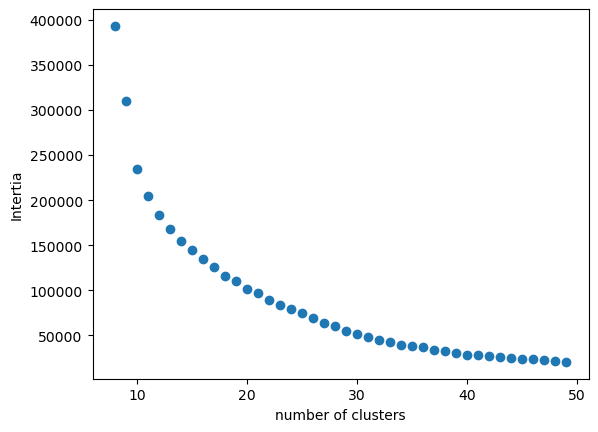

In [53]:
## Repeat as above but for just climate hazard

rows = []

    #subset the data
data = us_data_sample.loc[us_data_sample.Sect=='Climate Hazards']

#nlp
doc = list(nlp.pipe(data.Answer))
    
#vectorize
vectors=[tokens.vector for tokens in doc]
    
#embed
iso = Isomap(
n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
n_components=3, # number of dimensions
eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
metric='minkowski', # string, or callable, default=”minkowski”
p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
metric_params=None # default=None, Additional keyword arguments for the metric function.
)

X_trans = iso.fit_transform(vectors)


#Elbow plot to determine k neighbrs
x_cols = np.array(X_trans)
inertia = []

Ks=range(8,50)

for k in Ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertia.append(model.inertia_)

plt.scatter(Ks,inertia)
plt.xlabel("number of clusters")
plt.ylabel("Intertia")
plt.show()


Looks like 11 to me

In [54]:
#Create our KMEANS model but with 20 clusters
model = KMeans(n_clusters = 20, random_state = 10)
model.fit(x_cols)
labels = model.predict(x_cols)
labels.shape

Account_Num = data.Account_Num
Question_ID = data.Question_ID

#create a table with the cluster_ID added to Account_Num
cluster_df = pd.DataFrame({'Account_Num':Account_Num,'Question_ID':Question_ID, 'Label':labels})
ch_cluster_df = cluster_df
ch_cluster_df

Account_Num  Question_ID  Label
0           31177         7624      8
7           50550         7931      4
22          59563         7853      3
23          35870         7624      8
33          54104         7627      8
...           ...          ...    ...
4955        59642         8079      0
4956        31108         8383      6
4963        59535         7699      2
4991        50566         7547      8
4997        58871         8386      6

[923 rows x 3 columns]

In [55]:
ch_cluster_df['X'] = [array[0] for array in x_cols]
ch_cluster_df['Y'] = [array[1] for array in x_cols]
ch_cluster_df['Z'] = [array[2] for array in x_cols]
ch_cluster_df['Question_Label'] = (ch_cluster_df['Question_ID'].astype('str')) + '-' + (ch_cluster_df['Label'].astype('str'))
ch_cluster_df = ch_cluster_df.sort_values(['Question_ID','Label'])

In [56]:
# Create a 3D scatter plot
fig = px.scatter_3d(ch_cluster_df, 
                    x = 'X',
                    y = 'Y',
                    z = 'Z',
                    color='Label',
                    height=900, width=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", y=0, xanchor="center", x=0.5, traceorder="normal"),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=-1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

In [57]:
pivot_df = ch_cluster_df.pivot(index='Account_Num', columns='Question_ID', values='Label')

In [62]:
pivot_df

Question_ID  7547  7548  7549  7550  7551  7552  7553  7554  7555  7556  ...  \
Account_Num                                                              ...   
1184         11.0   NaN   NaN   8.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3203          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3417          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10495         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
10894         NaN   NaN   NaN   NaN   NaN   7.0   NaN   NaN   NaN   NaN  ...   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
74508         8.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
74531         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
74594         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
832838        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
841964        NaN   NaN  15.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

Question_ID  8610  8611  8630  8631  8650  8670  8671  8690  8710  8711  
Account_Num                                                              
1184          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3203          8.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   6.0   NaN  
3417          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
10495         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
10894         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
74508         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
74531         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
74594         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
832838        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
841964        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[114 rows x 178 columns]

In [63]:
test = pivot_df.loc[:,7547]
test.dropna(inplace=True)
len(test.unique())

4

In [87]:
#How many unique cluster groups do we have per question?

In [88]:
unique_counts=[]
for col in pivot_df.columns:
    column = pivot_df.loc[:,col]
    column.dropna(inplace=True)
    un_values = len(column.unique())
    counts = {"Question_ID":col,
              "Num_Unique_Clusters":un_values}
    unique_counts.append(counts)
unique_counts_df = pd.DataFrame(unique_counts).sort_values('Num_Unique_Clusters',ascending=False)
unique_counts_df.set_index('Question_ID')

Num_Unique_Clusters
Question_ID                     
8465                           6
8467                           5
8469                           4
8234                           4
7779                           4
...                          ...
7936                           1
7935                           1
7934                           1
7933                           1
8711                           1

[178 rows x 1 columns]

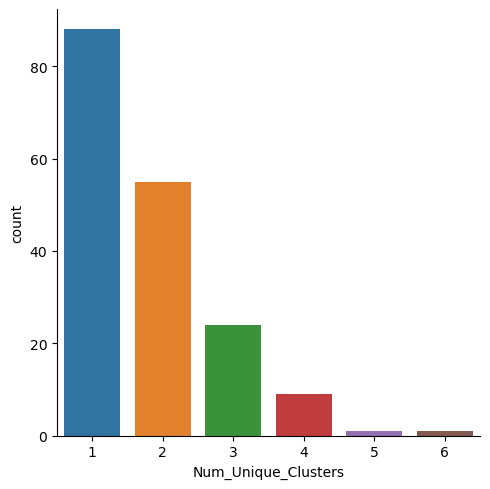

In [89]:
 p=sns.catplot(kind='count',\
                  data=unique_counts_df,
                  x='Num_Unique_Clusters')
plt.show()

Lets see which questions have 4 and 5 clusters

In [66]:
custers_4_5_list = list(unique_counts_df.query('Num_Unique_Clusters in [4,5]').Question_ID)

In [90]:
dim_qq_df.loc[dim_qq_df.Question_ID.isin(custers_4_5_list)].merge(data[['Question_ID','Answer']],on='Question_ID').drop_duplicates().head()

Question_ID  Year                        Parent_Sect             Sect  \
0         7547  2020  Climate Hazards and Vulnerability  Climate Hazards   
1         7547  2020  Climate Hazards and Vulnerability  Climate Hazards   
2         7547  2020  Climate Hazards and Vulnerability  Climate Hazards   
3         7547  2020  Climate Hazards and Vulnerability  Climate Hazards   
4         7547  2020  Climate Hazards and Vulnerability  Climate Hazards   

  Q_Num                                             Q_Name  Col_Num  \
0   2.1  Please list the most significant climate hazar...        1   
1   2.1  Please list the most significant climate hazar...        1   
2   2.1  Please list the most significant climate hazar...        1   
3   2.1  Please list the most significant climate hazar...        1   
4   2.1  Please list the most significant climate hazar...        1   

          Col_Name  Row_Num Row_Name  \
0  Climate Hazards        1      NaN   
1  Climate Hazards        1      NaN   
2  Climate Hazards        1      NaN   
3  Climate Hazards        1      NaN   
4  Climate Hazards        1      NaN   

                                       Answer  
0      Biological hazards > Air-borne disease  
1    Flood and sea level rise > Coastal flood  
2  Extreme hot temperature > Extreme hot days  
3                Storm and wind > Storm surge  
4          Extreme Precipitation > Rain storm

## Analysis 6: A deeper dive into the open ended questions

In [68]:
#find answers that are over 1000 characters
us_subset = us_data_sample[['Question_ID','Answer','Sect']]
us_subset['Answer_length']=us_subset.apply(lambda row: len(row.Answer),axis=1)
us_subset = us_subset.sort_values('Answer_length',ascending=False).head(50)
over_1000_word_responses = us_subset.loc[us_subset.Answer_length > 1000] 
over_1000_word_responses = over_1000_word_responses.groupby(['Question_ID','Sect'],as_index=False)['Answer_length'].mean()
over_1000_word_responses.head()

Question_ID                Sect  Answer_length
0          892  Adaptation Actions         1797.0
1          894  Adaptation Actions         1783.5
2          902  Adaptation Actions         1378.0
3          904  Adaptation Actions         1610.0
4         2360    Adaptation Goals         1294.0

In [91]:
over_1000_word_responses.shape[0]

39

In [70]:
over_1000_word_responses_list=list(over_1000_word_responses.Question_ID)

In [92]:
#subset us_data_Sample via the list above
open_ended_questions = us_data_sample.loc[us_data_sample.Question_ID.isin(over_1000_word_responses_list)]
open_ended_questions=open_ended_questions[['Account_Num','Question_ID','Sect','geometry','Answer']]
open_ended_questions

Account_Num  Question_ID                       Sect  \
50          54109        18046              Opportunities   
52          54075         8386            Climate Hazards   
55          54104        12997  Mitigation Target setting   
92          53959          894         Adaptation Actions   
96          31181          892         Adaptation Actions   
...           ...          ...                        ...   
4884        53959         8388            Climate Hazards   
4920       841964          894         Adaptation Actions   
4949        35853        14804                 Governance   
4956        31108         8383            Climate Hazards   
4997        58871         8386            Climate Hazards   

                      geometry  \
50    POINT (-86.5264 39.1653)   
52    POINT (-105.081 39.7047)   
55    POINT (-105.252 40.0274)   
92    POINT (-94.1719 36.0821)   
96    POINT (-75.1638 39.9523)   
...                        ...   
4884  POINT (-94.1719 36.0821)   
4920  POINT (-80.1484 25.9812)   
4949  POINT (-76.6122 39.2904)   
4956  POINT (-95.3694 29.7602)   
4997  POINT (-70.8967 42.5195)   

                                                 Answer  
50    Duke Energy’s 2018 Integrated Resource Energy ...  
52    Most published research suggests that annual s...  
55    Beginning as early as 2012, staff held several...  
92    Installing low impact development features whi...  
96    The Office of Sustainability and our partners ...  
...                                                 ...  
4884  With greater fluctuation in patterns of low pr...  
4920  Installed 5 tidal check valves in select storm...  
4949  The  City's Sustainability Plan and Climate Ac...  
4956  Extreme hot days increase energy use in buildi...  
4997  Some critical facilities will be affected. Pow...  

[209 rows x 5 columns]

In [73]:
#create a dictionary of lemma per answer
def lemma_dict(row):

    doc=nlp(row.Answer)
    lemma_counts = defaultdict(int)
    for token in doc:
        if not token.is_punct and not token.is_stop: 
            lemma = token.lemma_
            if lemma in lemma_counts:
                lemma_counts[lemma] += 1
            else:
                lemma_counts[lemma] = 1
    return lemma_counts

In [74]:
open_ended_questions['Lemma_Count']=open_ended_questions.apply(lambda row: lemma_dict(row),axis=1)
open_ended_questions.sort_values('Question_ID')

In [76]:
#which questions have over 10 users answering them (since all quesitons are optional)
open_ended_questions_groupby = open_ended_questions.groupby('Question_ID')['Account_Num']\
                    .count()\
                    .sort_values(ascending=False)
open_ended_questions_groupby=open_ended_questions_groupby.loc[open_ended_questions_groupby.values>=10]

In [77]:
open_ended_questions_groupby

Question_ID
8385     15
8387     14
8386     13
14804    11
892      10
Name: Account_Num, dtype: int64

In [78]:
# pull out data where answers are atleast 1000 chars and 10 different people answered it

open_ended_questions_top_10 = open_ended_questions.query("Question_ID.isin(@open_ended_questions_groupby.index)")\
            .sort_values('Question_ID')
open_ended_questions_top_10.head()

Account_Num  Question_ID                Sect                  geometry  \
456         63601          892  Adaptation Actions      POINT (-74.27 40.73)   
1050        52894          892  Adaptation Actions  POINT (-80.2442 36.0999)   
3474        43914          892  Adaptation Actions  POINT (-80.8431 35.2271)   
2232        59644          892  Adaptation Actions      POINT (-118.4 34.02)   
3769        52897          892  Adaptation Actions   POINT (-106.837 39.195)   

                                                 Answer  \
456   Replacing storm drainage piping, reinforcing c...   
1050  There were two major aspects of the project; 1...   
3474  Our 2030 SEAP goal drives the city to reduce c...   
2232  Culver City has a long-standing and active com...   
3769  Pitkin Alert is an emergency notification syst...   

                                            Lemma_Count  
456   {'replace': 1, 'storm': 1, 'drainage': 1, 'pip...  
1050  {'major': 1, 'aspect': 1, 'project': 2, '1': 1...  
3474  {'2030': 2, 'SEAP': 1, 'goal': 2, 'drive': 1, ...  
2232  {'Culver': 1, 'City': 2, 'long': 1, 'stand': 1...  
3769  {'Pitkin': 2, 'Alert': 1, 'emergency': 2, 'not...